# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [89]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/sunnypawat/mlfs-book
HopsworksSettings initialized!


In [90]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [91]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 18, 27, 6, 969506)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [92]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 18:27:08,596 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 18:27:08,601 INFO: Initializing external client
2025-11-18 18:27:08,602 INFO: Base URL: https://c.app.hopsworks.ai:443
Connection closed.
2025-11-18 18:27:08,601 INFO: Initializing external client
2025-11-18 18:27:08,602 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 18:27:10,429 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'

2025-11-18 18:27:10,429 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'p

2025-11-18 18:27:11,659 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296534

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296534


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [93]:
mr = project.get_model_registry()

# Task C: Retrieve the model 'air_quality_xgboost_model_lagged' from the model registry
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_lagged",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 18:27:20,338 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/527904 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115066 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26687 elapsed<00:00 remaining<?

In [94]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4129953E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [95]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-20 00:00:00+00:00,0.65,0.1,18.250259,22.011339,Stockholm
1,2025-11-19 00:00:00+00:00,-2.10,0.0,5.116561,320.710602,Stockholm
2,2025-11-21 00:00:00+00:00,1.20,0.0,16.965895,342.718414,Stockholm
3,2025-11-23 00:00:00+00:00,1.50,0.0,6.638072,229.398788,Stockholm
4,2025-11-22 00:00:00+00:00,-0.40,0.0,14.578890,212.905243,Stockholm
5,2025-11-24 00:00:00+00:00,2.80,0.0,11.269782,63.435013,Stockholm


In [96]:
### Task C: Get lagged features for batch inference
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

aq_history = air_quality_fg.read()[["date", "pm25"]]

aq_history

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 


,date,pm25
0,2022-01-05 00:00:00+00:00,12.0
1,2023-03-06 00:00:00+00:00,22.0
2,2020-01-11 00:00:00+00:00,27.0
3,2021-06-08 00:00:00+00:00,51.0
4,2022-05-15 00:00:00+00:00,9.0
...,...,...
2520,2024-01-11 00:00:00+00:00,8.0
2521,2020-10-08 00:00:00+00:00,17.0
2522,2023-04-09 00:00:00+00:00,38.0
2523,2022-07-15 00:00:00+00:00,6.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [97]:
# Normalize dates and sort
aq_history = aq_history.copy()
aq_history['date'] = pd.to_datetime(aq_history['date'])
aq_history = aq_history.sort_values('date')

batch_data = batch_data.copy()
batch_data['date'] = pd.to_datetime(batch_data['date'])
batch_data = batch_data.sort_values('date').reset_index(drop=True)

# Build a lookup for known/seeded pm25 values (historical)
pm25_lookup = {pd.Timestamp(d): float(v) for d, v in zip(aq_history['date'], aq_history['pm25'])}

# Feature columns expected by the model
weather_cols = [
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant',
]
lag_cols = ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']
model_feature_cols = weather_cols + lag_cols

# Ensure lag columns exist
for c in lag_cols + ['predicted_pm25']:
    if c not in batch_data.columns:
        batch_data[c] = pd.NA

# Use last historical pm25 as fallback if necessary
if len(aq_history) > 0:
    last_hist_pm25 = float(aq_history['pm25'].dropna().iloc[-1])
else:
    last_hist_pm25 = 0.0

# Iterate unique batch dates in ascending order, predicting per-date
batch_dates = sorted(batch_data['date'].unique())

for d in batch_dates:
    mask = batch_data['date'] == d

    # Fill lagged values from lookup (which will be augmented with predictions as we go)
    for lag in (1, 2, 3):
        lookup_date = pd.Timestamp(d - pd.Timedelta(days=lag))
        val = pm25_lookup.get(lookup_date, None)
        if val is None:
            # leave NaN for now; will fill with fallback below
            batch_data.loc[mask, f'pm25_lag_{lag}'] = pd.NA
        else:
            batch_data.loc[mask, f'pm25_lag_{lag}'] = val

    # Prepare features for prediction; if weather columns are missing, raise a helpful error
    missing_weather = [c for c in weather_cols if c not in batch_data.columns]
    if missing_weather:
        raise RuntimeError(f"Missing required weather columns in `batch_data`: {missing_weather}")

    X_row = batch_data.loc[mask, model_feature_cols].copy()

    # Fill missing lag values with sensible fallback (last historical pm25)
    X_row[lag_cols] = X_row[lag_cols].fillna(last_hist_pm25)

    # If any remaining NaNs (shouldn't happen), fill with column mean
    X_row = X_row.fillna(X_row.mean(numeric_only=True))

    # Convert to numeric dtype for model
    X_row = X_row.astype(float)

    if X_row.shape[0] == 0:
        continue

    # Predict for all rows of this date
    preds = retrieved_xgboost_model.predict(X_row[model_feature_cols])

    # Assign predictions back
    batch_data.loc[mask, 'predicted_pm25'] = preds

    # Seed the lookup with the day's prediction for recursive use by later dates.
    # If multiple rows for the same date, use the mean as the seed value.
    seed_val = float(pd.Series(preds).mean())
    pm25_lookup[pd.Timestamp(d)] = seed_val

# Finalize: create batch_data_lagged for downstream steps
batch_data_lagged = batch_data.copy()

print('Recursive prediction completed.' )
print('Batch rows:', len(batch_data_lagged))
print('Sample rows with predictions:')
print(batch_data_lagged.loc[batch_data_lagged['predicted_pm25'].notna()].head())

batch_data_lagged  


2025-11-18 18:27:37,411 WARNING: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



2025-11-18 18:27:37,426 WARNING: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

2025-11-18 18:27:37,436 WARNING: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

2025-11-18 18:27:37,436 WARNING: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

2025-11-18 18:27:37,447 WARNING: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2025-11-19 00:00:00+00:00,-2.10,0.0,5.116561,320.710602,Stockholm,45.0,12.0,15.0,51.579159
1,2025-11-20 00:00:00+00:00,0.65,0.1,18.250259,22.011339,Stockholm,51.579159,45.0,12.0,30.999971
2,2025-11-21 00:00:00+00:00,1.20,0.0,16.965895,342.718414,Stockholm,30.999971,51.579159,45.0,21.976444
3,2025-11-22 00:00:00+00:00,-0.40,0.0,14.578890,212.905243,Stockholm,21.976444,30.999971,51.579159,30.990206
4,2025-11-23 00:00:00+00:00,1.50,0.0,6.638072,229.398788,Stockholm,30.990206,21.976444,30.999971,45.675865
5,2025-11-24 00:00:00+00:00,2.80,0.0,11.269782,63.435013,Stockholm,45.675865,30.990206,21.976444,45.984734


In [98]:
batch_data_lagged['predicted_pm25'] = batch_data_lagged['predicted_pm25'].astype('float32')
batch_data_lagged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   6 non-null      object                 
 7   pm25_lag_2                   6 non-null      object                 
 8   pm25_lag_3                   6 non-null      object                 
 9   predicted_pm25               6 non-null      float32                
dtypes: dat

In [99]:
batch_data = batch_data_lagged
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2025-11-19 00:00:00+00:00,-2.10,0.0,5.116561,320.710602,Stockholm,45.0,12.0,15.0,51.579159
1,2025-11-20 00:00:00+00:00,0.65,0.1,18.250259,22.011339,Stockholm,51.579159,45.0,12.0,30.999971
2,2025-11-21 00:00:00+00:00,1.20,0.0,16.965895,342.718414,Stockholm,30.999971,51.579159,45.0,21.976444
3,2025-11-22 00:00:00+00:00,-0.40,0.0,14.578890,212.905243,Stockholm,21.976444,30.999971,51.579159,30.990206
4,2025-11-23 00:00:00+00:00,1.50,0.0,6.638072,229.398788,Stockholm,30.990206,21.976444,30.999971,45.675865
5,2025-11-24 00:00:00+00:00,2.80,0.0,11.269782,63.435013,Stockholm,45.675865,30.990206,21.976444,45.984734


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [100]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data.drop(columns=['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3'], inplace=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-2.10,0.0,5.116561,320.710602,Stockholm,51.579159,st-eriksgatan-83,Sweden,1
1,2025-11-20 00:00:00+00:00,0.65,0.1,18.250259,22.011339,Stockholm,30.999971,st-eriksgatan-83,Sweden,2
2,2025-11-21 00:00:00+00:00,1.20,0.0,16.965895,342.718414,Stockholm,21.976444,st-eriksgatan-83,Sweden,3
3,2025-11-22 00:00:00+00:00,-0.40,0.0,14.578890,212.905243,Stockholm,30.990206,st-eriksgatan-83,Sweden,4
4,2025-11-23 00:00:00+00:00,1.50,0.0,6.638072,229.398788,Stockholm,45.675865,st-eriksgatan-83,Sweden,5
5,2025-11-24 00:00:00+00:00,2.80,0.0,11.269782,63.435013,Stockholm,45.984734,st-eriksgatan-83,Sweden,6


In [101]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: dat

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

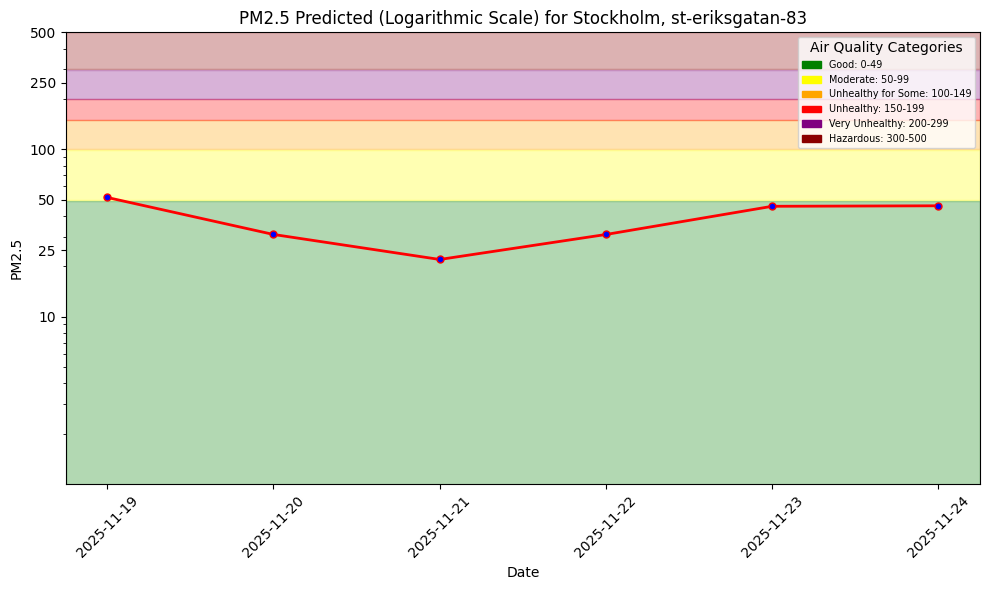

In [102]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [103]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [104]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:06 | Remaining Time: 00:00



Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296534/jobs/named/aq_predictions_1_offline_fg_materialization/executions
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296534/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 18:28:43,644 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 18:28:43,644 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 18:28:46,818 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 18:28:46,818 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 18:30:16,688 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 18:30:16,688 INFO: Waiting for e

(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [113]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,0.500000,0.0,14.264361,10.175456,Stockholm,15.190783,st-eriksgatan-83,Sweden,1
1,2025-11-15 00:00:00+00:00,-0.004333,0.0,19.091883,269.060303,Stockholm,20.342947,st-eriksgatan-83,Sweden,1
2,2025-11-16 00:00:00+00:00,0.987333,0.3,18.116623,253.325562,Stockholm,21.365282,st-eriksgatan-83,Sweden,1
3,2025-11-17 00:00:00+00:00,-0.450000,0.0,10.948973,316.332153,Stockholm,36.177101,st-eriksgatan-83,Sweden,1
4,2025-11-14 00:00:00+00:00,1.118583,0.0,16.800856,291.999786,Stockholm,26.656633,st-eriksgatan-83,Sweden,1
5,2025-11-19 00:00:00+00:00,-2.100000,0.0,5.116561,320.710602,Stockholm,51.579159,st-eriksgatan-83,Sweden,1


In [112]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.69s) 


,date,pm25,country,city,street,url
0,2022-01-05 00:00:00+00:00,12.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
1,2023-03-06 00:00:00+00:00,22.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2,2020-01-11 00:00:00+00:00,27.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
3,2021-06-08 00:00:00+00:00,51.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
4,2022-05-15 00:00:00+00:00,9.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
...,...,...,...,...,...,...
2520,2024-01-11 00:00:00+00:00,8.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2521,2020-10-08 00:00:00+00:00,17.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2522,2023-04-09 00:00:00+00:00,38.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2523,2022-07-15 00:00:00+00:00,6.0,Sweden,Stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523


In [110]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
3,2025-11-14 00:00:00+00:00,26.656633,13.0
0,2025-11-15 00:00:00+00:00,20.342947,12.0
1,2025-11-16 00:00:00+00:00,21.365282,15.0
2,2025-11-17 00:00:00+00:00,36.177101,12.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

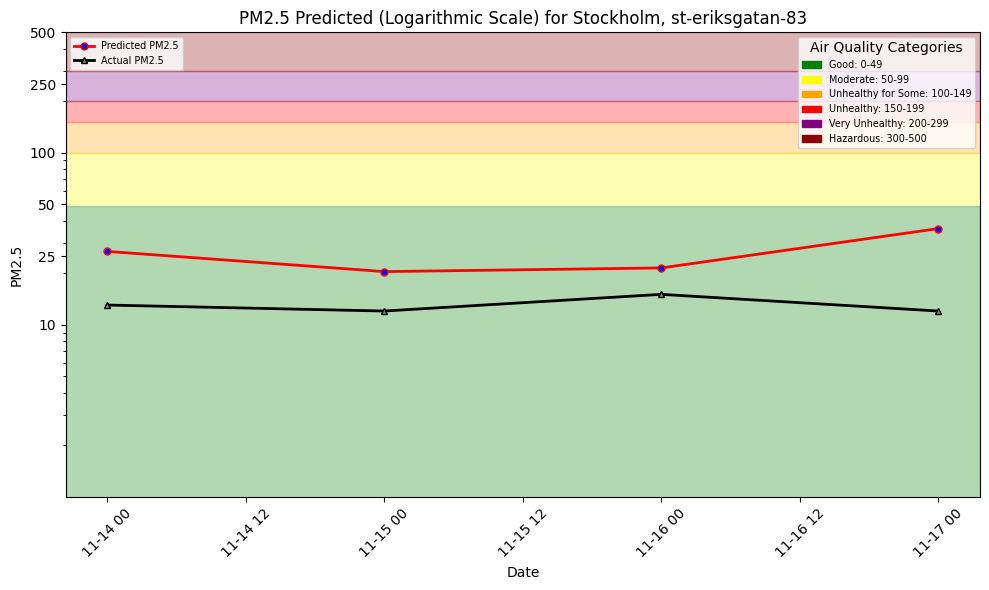

In [114]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [115]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/sunnypawat/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/46587…

Uploading /home/sunnypawat/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296534/settings/fb/path/Resources/airquality


---